# SCP Toolbox Workshop

___A tutorial on generating dynamically feasible trajectories reliably and efficiently___

Monday, February 7, 2022

Rocky Mountain AAS GN&C Conference, Breckenridge, CO

In [1]:
import Pkg
Pkg.activate("..")

# these lines are required only for local installations
Pkg.develop(path="../../scp_traj_opt/")
Pkg.precompile()

using SCPToolbox
using PyPlot, Colors, LinearAlgebra

# Import the different possible low-level convex solvers
using COSMO
using Ipopt
using SCS
using ECOS
using OSQP

  Activating project at `~/GitHub/SCPToolbox_tutorial`
   Resolving package versions...
  No Changes to `~/GitHub/SCPToolbox_tutorial/Project.toml`
  No Changes to `~/GitHub/SCPToolbox_tutorial/Manifest.toml`


# Part 4: Rocket-Landing Guidance

In this part of the tutorial, you will participate in formulating and solving a Lunar rocket landing trajectory optimization problem.

The rocket has a 2-dimensional position and a rotation, and a gimbaled rocket engine. The goal is to take the rocket from an airborne state to a soft touchdown on the ground.

<center>
    <img src="media/p4-rocket-landing-overview.png"
         alt="Dubin's car overview"
         style="background-color: white; width: 300px; display: block; margin-left: auto; margin-right: auto;"/>
    <br />
    <b>Figure.</b> Illustration of the rocket soft landing problem.
    <br />
    <br />
</center>

Begin by defining a new `TrajectoryProblem` object.

In [2]:
pbm = TrajectoryProblem(); # Enter your code here

<details>

<summary>Answer</summary>



```julia
pbm = TrajectoryProblem();
```
</details>

## Rocket parameters

Any trajectory optimization problem begins by defining the constant parameters of the problem. For example, how much does the rocket weigh? How high up does it start?

We define these below.

In [3]:
# Environment parameters
g = 1.625 # [m/s^2] Gravitational acceleration of the planet
g_E = 9.807; # [m/s^2] Earth gravity

In [4]:
# Mechanical parameters
m_wet = 25e3 # [kg] Initial mass
L = 0.5 # [m] Thrust lever arm
J = 100e3; # [kg*m^2] Moment of inertia

In [5]:
# Propulsion parameters
Isp = 370 # [s] Specific impulse
T_min = 20e3 # [N] Minimum thrust
T_max = 80e3 # [N] Maximum thrust
α = 1 / (Isp * g_E) # [kg/s/N] Fuel consumption rate coefficient
δ_max = deg2rad(10.0); # [rad] Maximum gimbal angle

In [6]:
# Trajectory parameters
γ_gs = deg2rad(45.0); # [rad] Glideslope angle (measured from the horizon)

## Rocket dynamics

The partial rocket dynamics are given by the following ordinary differential equations:

\begin{align}
\dot x &= v_x, \\
\dot y &= \mathrm{\color{grey}{TODO}}, \\
\dot v_x &= -\frac{T}{m}\sin(\theta+\delta), \\
\dot v_y &= \mathrm{\color{grey}{TODO}}, \\
\dot \theta &= \mathrm{\color{grey}{TODO}}, \\
\dot \omega &= -\frac{LT}{J}\sin(\delta), \\
\dot m &= -\alpha T.
\end{align}

<details>

<summary>Answer</summary>

\begin{align}
    \dot y &= v_y, \\
    \dot v_y &= \frac{T}{m}\cos(\theta+\delta)-g, \\
    \dot \theta &= \omega.
\end{align}

</details>

Define the state vector $x\in\mathbb R^n$, with the elements in the same order as they appear on the left-hand side of the ordinary differential equations above:

$$
x = \begin{bmatrix}
\mathrm{\color{grey}{TODO}}
\end{bmatrix}.
$$

<details>

<summary>Answer</summary>

$$
x = \begin{bmatrix}
x \\ y \\ v_x \\ v_y \\ \theta \\ \omega \\ m
\end{bmatrix}
$$

</details>

Define the input vector $u\in\mathbb R^m$, with the thrust coming first:

$$
u = \begin{bmatrix}
\mathrm{\color{grey}{TODO}}
\end{bmatrix}.
$$

<details>

<summary>Answer</summary>

$$
u = \begin{bmatrix}
T \\ \delta
\end{bmatrix}
$$

</details>

Complete the function below that evaluates the right-hand side of the dynamics ordinary differential equations above. The function signature is:

$$
\dot x = f_{rocket}(x, u),
$$

where the arguments are the state and input and the output is the state time derivative.

In [7]:
f_rocket(x, u) = begin
    rx, ry, vx, vy, θ, ω, m = x
    T, δ = u
    # Enter your code here
    return [vx; vy; -(T/m)*sin(θ+δ); (T/m)*cos(θ+δ)-g; ω; -(L*T/J)*sin(δ); -α*T]
end;

<details>

<summary>Answer</summary>

```julia
f_rocket(x, u) = begin
    rx, ry, vx, vy, θ, ω, m = x
    T, δ = u
    return [vx; vy; -(T/m)*sin(θ+δ); (T/m)*cos(θ+δ)-g; ω; -(L*T/J)*sin(δ); -α*T]
end;
```

</details>

Remember from the Dubin's car example that SCP Toolbox operates on a normalized-time problem where time takes values in $[0,1]$.

We are going to solve a free-final time rocket landing problem, and this requires us to introduce a one-element parameter vector that holds the time dilation coefficient:

$$
p = \begin{bmatrix}
t_f
\end{bmatrix}.
$$

The normalized-time dynamics are given by:

$$
\dot x = t_f f_{rocket}(x, u) \equiv f(x, u, p).
$$

This allows us to write the normalized-time dynamics in Julia as follows.

In [8]:
f(x, u, p) = begin
    tf, = p
    f_rocket(x, u)*tf
end;

Based on the above definitions of the state ($x$), the input ($u$), and the parameter ($p$), record their dimensions ($n$, $m$, and $d$, respectively).

In [9]:
n = 7 # Enter your code here
m = 2 # Enter your code here
d = 1 # Enter your code here

1

<details>

<summary>Answer</summary>

```julia
n = 7
m = 2
d = 1
```

</details>

Use the SCP Toolbox API to define the state, input, and parameter dimensions in the problem.

In [10]:
problem_set_dims!(pbm, n, m, d) # Enter your code here

<details>

<summary>Answer</summary>

```julia
problem_set_dims!(pbm, n, m, d)
```

</details>

### Jacobians

We need to define the Jacobians of the dynamics with respect to the state, input, and parameter vectors.

Remember the definition of the Jacobian of a general function $g(z):\mathbb R^n\to\mathbb R^m$:

$$
\nabla_z g(z) = \begin{bmatrix}
\frac{\partial g(z)}{\partial z_1} &
\frac{\partial g(z)}{\partial z_2} &
\cdots &
\frac{\partial g(z)}{\partial z_n}
\end{bmatrix}\in\mathbb R^{m\times n}.
$$

With the above in mind, write down "in math" the Jacobian of the dynamics with respect to $x$:

$$
A(x, u, p) = \nabla_x f(x, u, p) = \begin{bmatrix}
\mathrm{\color{grey}{TODO}}
\end{bmatrix}\in\mathbb R^{n\times n}.
$$

To help, here is what the column corresponding to the state $x_5\equiv\theta$ looks like:

$$
\begin{bmatrix}
0\\0\\- \frac{T t_f \cos{\left(\delta + \theta \right)}}{m}\\- \frac{T t_f \sin{\left(\delta + \theta \right)}}{m}\\0\\0\\0\end{bmatrix}.
$$

<details>

<summary>Answer</summary>

$$
A(x, u, p) = 
\begin{bmatrix}
0 & 0 & t_f & 0 & 0 & 0 & 0\\
0 & 0 & 0 & t_f & 0 & 0 & 0\\
0 & 0 & 0 & 0 & - \frac{T t_f \cos{\left(\delta + \theta \right)}}{m} & 0 & \frac{T t_f \sin{\left(\delta + \theta \right)}}{m^{2}}\\0 & 0 & 0 & 0 & - \frac{T t_f \sin{\left(\delta + \theta \right)}}{m} & 0 & - \frac{T t_f \cos{\left(\delta + \theta \right)}}{m^{2}}\\0 & 0 & 0 & 0 & 0 & t_f & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0\end{bmatrix}.
$$

</details>

Now implement the function in Julia.

In [11]:
A(x, u, p) = begin
    rx, ry, vx, vy, θ, ω, m = x
    T, δ = u
    tf, = p
    # Enter your code here
    return [0 0 1 0       0       0       0
            0 0 0 1       0       0       0
            0 0 0 0 -T/m*cos(θ+δ) 0 T/m^2*sin(θ+δ)
            0 0 0 0 -T/m*sin(θ+δ) 0 -T/m^2*cos(θ+δ)
            0 0 0 0       0       1       0
            0 0 0 0       0       0       0
            0 0 0 0       0       0       0]*tf
end;

<details>

<summary>Answer</summary>

```julia
A(x, u, p) = begin
    rx, ry, vx, vy, θ, ω, m = x
    T, δ = u
    tf, = p
    return [0 0 1 0       0       0       0
            0 0 0 1       0       0       0
            0 0 0 0 -T/m*cos(θ+δ) 0 T/m^2*sin(θ+δ)
            0 0 0 0 -T/m*sin(θ+δ) 0 -T/m^2*cos(θ+δ)
            0 0 0 0       0       1       0
            0 0 0 0       0       0       0
            0 0 0 0       0       0       0]*tf
end
```

</details>

Similarly, write down the Jacobian with respect to the input, $u$:

$$
B(x, u, p) = \nabla_u f(x, u, p) = \begin{bmatrix}
\mathrm{\color{grey}{TODO}}
\end{bmatrix}\in\mathbb R^{n\times m}.
$$

<details>

<summary>Answer</summary>

$$
B(x, u, p) = 
\begin{bmatrix}
0 & 0\\0 & 0\\- \frac{t_f \sin{\left(\delta + \theta \right)}}{m} & - \frac{T t_f \cos{\left(\delta + \theta \right)}}{m}\\\frac{t_f \cos{\left(\delta + \theta \right)}}{m} & - \frac{T t_f \sin{\left(\delta + \theta \right)}}{m}\\0 & 0\\- \frac{L t_f \sin{\left(\delta \right)}}{J} & - \frac{L T t_f \cos{\left(\delta \right)}}{J}\\- \alpha t_f & 0
\end{bmatrix}.
$$

</details>

Now implement the function in Julia.

In [12]:
B(x, u, p) = begin
    rx, ry, vx, vy, θ, ω, m = x
    T, δ = u
    tf, = p
    # Enter your code here
    return [     0            0
                 0            0
            -sin(θ+δ)/m -T/m*cos(θ+δ)
             cos(θ+δ)/m -T/m*sin(θ+δ)
                 0            0
            -L/J*sin(δ) -L*T/J*cos(δ)
                -α            0       ]*tf
end;

<details>

<summary>Answer</summary>

```julia
B(x, u, p) = begin
    rx, ry, vx, vy, θ, ω, m = x
    T, δ = u
    tf, = p
    return [     0            0
                 0            0
            -sin(θ+δ)/m -T/m*cos(θ+δ)
             cos(θ+δ)/m -T/m*sin(θ+δ)
                 0            0
            -L/J*sin(δ) -L*T/J*cos(δ)
                -α            0       ]*tf
end
```

</details>

Finally, write down the Jacobian with respect to the parameter vector, $p$:

$$
F(x, u, p) = \nabla_p f(x, u, p) = \begin{bmatrix}
\mathrm{\color{grey}{TODO}}
\end{bmatrix}\in\mathbb R^{n\times d}.
$$

<details>

<summary>Answer</summary>

$$
F(x, u, p) = 
f_{rocket}(x, u).
$$

</details>

Now implement the function in Julia.

In [13]:
F(x, u, p) = begin
    rx, ry, vx, vy, θ, ω, m = x
    T, δ = u
    tf, = p
    # Enter your code here
    return reshape(f(x, u, p)/tf, 7, 1)
end;

<details>

<summary>Answer</summary>

```julia
F(x, u, p) = begin
    rx, ry, vx, vy, θ, ω, m = x
    T, δ = u
    tf, = p
    return reshape(f(x, u, p)/tf, 7, 1)
end;
```

</details>

The SCP Toolbox API also passes other arguments to the dynamics and its Jacobians:
* `t`: the time;
* `k`: the discrete time index;
* `pbm`: the `TrajectoryProblem` object that we defined at the very beginning.

We write a simple wrapper to satisfy the API.

In [14]:
wrap(func) = (t, k, x, u, p, pbm) -> func(x, u, p);
f_scp = wrap(f)
A_scp = wrap(A)
B_scp = wrap(B)
F_scp = wrap(F)

#1 (generic function with 1 method)

Use the above functions `f_scp`, `A_scp`, `B_scp`, `F_scp` in order to define the dynamics using the SCP Toolbox API.

In [15]:
# Enter your code here
problem_set_dynamics!(pbm, f_scp, A_scp, B_scp, F_scp)

<details>

<summary>Answer</summary>

```julia
problem_set_dynamics!(pbm, f_scp, A_scp, B_scp, F_scp)
```

</details>

## Boundary Conditions

Let's define the boundary conditions on the state as a fixed "airborne" point above the landing site at the start, and a point at the landing state at the end of the trajectory. Because the rocket depletes mass, and we do not know by how much ahead of time, the final mass is left unspecified.

In [16]:
km2m(x) = x*1e3 # Conversion from km to m
kph2mps(v) = v/3.6 # Conversion from km/h to m/s

# Initial state
x_0 = [km2m(0.5)
       km2m(1.4)
       kph2mps(80)
       kph2mps(-100)
       deg2rad(-30.0)
       deg2rad(0.0)
       m_wet]

# Terminal state (without mass)
x_f = zeros(6);

Recall that the boundary conditions are defined as the equality constraints:

\begin{align}
g_{ic}(x(0), p) &= 0, \\
g_{tc}(x(1), p) &= 0.
\end{align}

Given the definitions of $x_0$ (`x_0`) and $x_f$ (`x_f`), define the $g_{ic}$ and $g_{tc}$ functions.

\begin{align}
g_{ic}(x, p) &= \mathrm{\color{grey}{TODO}}, \\
g_{tc}(x, p) &= \mathrm{\color{grey}{TODO}}.
\end{align}

<details>

<summary>Answer</summary>

\begin{align}
g_{ic}(x, p) &= x-x_0, \\
g_{tc}(x, p) &= E_{m} x-x_f,
\end{align}
where:
$$
E_{m} = \begin{bmatrix}
I\in\mathbb R^{6\times 6} &\mid & 0
\end{bmatrix}\in\mathbb R^{6\times 7}.
$$

</details>

Now implement these functions in Julia.

In [17]:
g_ic(x, p) = x-x_0 # Enter your code here
g_tc(x, p) = x[1:6]-x_f; # Enter your code here

<details>

<summary>Answer</summary>

```julia
g_ic(x, p) = x-x_0
g_tc(x, p) = x[1:6]-x_f;
```

</details>

Again, we need to provide the Jacobians of $g_{ic}$ and $g_{tc}$ for the SCP algorithm to work with. This is needed because, in general, these may be nonaffine functions. Define the following Jacobians:

\begin{align}
H_0(x(0), p) &= \nabla_x g_{ic}(x(0), p), \\
K_0(x(0), p) &= \nabla_p g_{ic}(x(0), p), \\
H_f(x(1), p) &= \nabla_x g_{tc}(x(1), p), \\
K_f(x(1), p) &= \nabla_p g_{tc}(x(1), p).
\end{align}

When a Jacobian is not provided, the SCP Toolbox assumes that it is zero. Write down the non-zero Jacobians for $g_{ic}$ and $g_{tc}$ (omit those that are zero).

\begin{align}
H_0(x(0), p) &= \mathrm{\color{grey}{TODO}}, \\
K_0(x(0), p) &= \mathrm{\color{grey}{TODO}}, \\
H_f(x(1), p) &= \mathrm{\color{grey}{TODO}}, \\
K_f(x(1), p) &= \mathrm{\color{grey}{TODO}}.
\end{align}

<details>

<summary>Answer</summary>
\begin{align}
H_0(x(0), p) &= I\in\mathbb R^{7\times 7}, \\
H_f(x(1), p) &= \begin{bmatrix} I\in\mathbb R^{6\times 6} & 0\end{bmatrix}\in\mathbb R^{6\times 7}.
\end{align}

</details>

Now implement the non-zero Jacobians in Julia. You can delete the lines for the zero Jacobians.

In [18]:
H_0(x, p) = I(7) # Enter your code here
H_f(x, p) = collect(hcat(I(6), zeros(6))); # Enter your code here

<details>

<summary>Answer</summary>

```julia
H_0(x, p) = I(7)
H_f(x, p) = collect(hcat(I(6), zeros(6)));
```

</details>

We now use the SCP Toolbox API in order to associate the boundary conditions with the trajectory optimization problem. The code below configures the above functions to accept the arguments that the toolbox will provide them with. The API function `problem_set_bc!` is then used to link the boundary conditions to the trajectory problem.

Your job is to uncomment the `problem_set_bc!` calls, and remove the zero Jacobians from each call.

In [19]:
wrap(func) = (x, p, pbm) -> func(x, p)
# problem_set_bc!(pbm, :ic, wrap(g_ic), wrap(H_0), wrap(K_0))
# problem_set_bc!(pbm, :tc, wrap(g_tc), wrap(H_f), wrap(K_f));
problem_set_bc!(pbm, :ic, wrap(g_ic), wrap(H_0))
problem_set_bc!(pbm, :tc, wrap(g_tc), wrap(H_f));

<details>

<summary>Answer</summary>

```julia
problem_set_bc!(pbm, :ic, wrap(g_ic), wrap(H_0))
problem_set_bc!(pbm, :tc, wrap(g_tc), wrap(H_f));
```

</details>

## State Constraints

In order to not collide with the ground or any obstacles (such as hills) surrounding the landing site, the rocket's position is constrained to be above a certain glideslope, as illustrated in the figure at the top of this notebook.

Write down the glideslope constraint on the position vector $[x;y]$. (Hint: it is a convex inequality and involves $|x|$).

$$
\mathrm{\color{grey}{TODO}}\le 0.
$$

<details>

<summary>Answer</summary>

$$
|x|-\frac{y}{\tan(\gamma_{gs})}\le 0.
$$

</details>

What kind of convex cone can represent this constraint?

Enter your answer in term of the Julia variable that is used to by the SCP Toolbox to denote the cone (recall the table from the Part 1 notebook): `TODO`.

<details>

<summary>Answer</summary>

`L1`

</details>

Now use the SCP Toolbox's `@add_constraint` macro (which you learned about in Part 1) in order to define the glideslope constraint. Assume that the function receives `x` (the full state vector) and `clp` (the `ConicProgram` object).

In [20]:
# Enter your code here
glideslope(x, clp) = @add_constraint(clp, L1, x -> begin
        x, y = x[1], x[2]
        return [y/tan(γ_gs); x]
    end);

<details>

<summary>Answer</summary>

```julia
glideslope(x, clp) = @add_constraint(clp, L1, x -> begin
        x, y = x[1], x[2]
        return [y/tan(γ_gs); x]
    end);
```
    
</details>

Let's associate this constraint with the trajectory problem using the SCP Toolbox API for convex state constraints.

In [21]:
problem_set_X!(pbm, (t, k, x, p, pbm, clp) -> glideslope(x, clp))

## Control Constraints

The control constraints ensure that the rocket's propulsion system can actually reproduce the inputs that are computed by the optimal trajectory.

For this problem, we will constraint the thrust to $T\in [T_{\min}, T_{\max}]$ and the gimbal angle $\delta\in [-\delta_{\max},\delta_{\max}]$.

Write these control constraints as cones. Write the constraints separately for thrust lower bound, upper bound, and gimbal angle (thus you should end up with 3 cones). Only use the cones that are supported by the SCP Toolbox (refer to Part 1).

<details>

<summary>Answer</summary>

\begin{align*}
T_{\min}-T &\in \mathbb K_{\le 0}, \\
T-T_{\max} &\in \mathbb K_{\le 0}, \\
\begin{bmatrix}
\delta_{\max} \\ \delta
\end{bmatrix} &\in \mathbb K_{1}.
\end{align*}
    
</details>

Now implement each constraint in Julia using `@add_constraint`.

In [22]:
# Enter your code here
thrust_upper_bound(T, clp) = @add_constraint(clp, NONPOS, T -> T-T_max)
thrust_lower_bound(T, clp) = @add_constraint(clp, NONPOS, T -> T_min-T)
gimbal_limit(δ, clp) = @add_constraint(clp, L1, δ -> vcat(δ_max, δ));

<details>

<summary>Answer</summary>

```julia
thrust_upper_bound(T, clp) = @add_constraint(clp, NONPOS, T -> T-T_max)
thrust_lower_bound(T, clp) = @add_constraint(clp, NONPOS, T -> T_min-T)
gimbal_limit(δ, clp) = @add_constraint(clp, L1, δ -> vcat(δ_max, δ));
```
    
</details>

Now call the SCP Toolbox API function `problem_set_U!` in order to associate the convex input constraints with the trajectory problem.

In [23]:
problem_set_U!(pbm, (t, k, u, p, pbm, clp) -> begin
        # Enter your code here
        T, δ = u[1], u[2]
        thrust_upper_bound(T, clp)
        thrust_lower_bound(T, clp)
        gimbal_limit(δ, clp)
    end)

<details>

<summary>Answer</summary>

```julia
problem_set_U!(pbm, (t, k, u, p, pbm, clp) -> begin
        T, δ = u[1], u[2]
        thrust_upper_bound(T, clp)
        thrust_lower_bound(T, clp)
        gimbal_limit(δ, clp)
    end)
```
    
</details>

## Objective Function

A common objective for rocket landing guidance is to compute a trajectory that uses the least amount of fuel. This results in a lighter vehicle design that can carry more useful scientific payload, and other beneficial tradeoffs.

Minimizing fuel use is equivalent to maxizing the final mass of the rocket (since the least amount of fuel will have then been depleted). The SCP Toolbox seeks to __minimize__ the following objective function:

$$
J(x, u, p) = \phi(x(1), p) + \int_0^1 \Gamma(x(t), u(t), p) dt.
$$

Define $\phi$ and $\Gamma$ for maximizing the final mass:

\begin{align*}
\phi(x(1), p) &= \mathrm{\color{grey}{TODO}}, \\
\Gamma(x(t), u(t), p) &= \mathrm{\color{grey}{TODO}}.
\end{align*}

Be sure to _normalize_ the functions, meaning that you should multiply them by a constant coefficient such that along any reasonable trajectory the following (approximately) hold: $\phi(\cdot)\in [0,1]$ and $\Gamma(\cdot)\in [0,1]$.

(Hint: one of the functions may have to be zero!)

<details>

<summary>Answer</summary>

\begin{align*}
\phi(x(1), p) &= -\frac{ m(1) }{ m_{wet} }, \\
\Gamma(x(t), u(t), p) &= 0.
\end{align*}
    
</details>

Now implement the functions in Julia. (Hint: you can delete any function that is zero).

In [24]:
ϕ(x, p) = -x[end]/m_wet; # Enter your code here
# Γ(x, u, p) = # Enter your code here

<details>

<summary>Answer</summary>

```julia
ϕ(x, p) = -x[end]/m_wet;
```
    
</details>

We now have to pass the above functions to the objective function definition of the trajectory problem. The SCP Toolbox allows us to do this via the API functions `problem_set_terminal_cost!` and `problem_set_running_cost!`. If either one is missing, you can omit the call and it will be assumed that the corresponding part of the objective is zero.

In the cell below, uncomment the lines corresponding to the non-zero components of the cost.

In [25]:
problem_set_terminal_cost!(pbm, (x, p, pbm) -> ϕ(x, p))
# problem_set_running_cost!(pbm, (t, k, x, u, p, pbm) -> Γ(x, u, p))

<details>

<summary>Answer</summary>

```julia
problem_set_terminal_cost!(pbm, (x, p, pbm) -> ϕ(x, p));
```
    
</details>

## Initial Trajectory Guess

The initial trajectory guess is required to get an SCP algorithm started. This guess can be quite coarse, and does not need to be feasible with respect to the dynamics and nonconvex constraints. Some SCP algorithms require the guess to be feasible with respect to the convex constraints, which is usually easy to do (in fact, it can be done automatically via a convex projection).

A straight-line guess is sufficient for the rocket landing problem. The following code interpolates from the initial to the final condition. The duration is set to the time it would take an average thrust to slow the rocket down to a hover. The angular rate is set to a constant value that rotates the rocket from its initial tilt to the final upright orientation.

In [26]:
T_guess = T_min+0.5*(T_max-T_min) # [N] Initial thrust guess
v_0, v_f = x_0[3:4], x_f[3:4]
tf_guess = norm(v_f-v_0, 2)/(T_guess/m_wet-g)
Δm_guess = -α*T_guess*tf_guess
m_dry_guess = x_0[end]+Δm_guess

state_guess(N) = begin
    x_guess = straightline_interpolate(x_0, vcat(x_f, m_dry_guess), N)
    x_guess[6, :] .= (x_f[5]-x_0[5])/tf_guess
    return x_guess
end;

Let's guess the input to be a constant thrust of `T_guess` amount, and zero gimbal angle. Complete the following function using `straightline_interpolate`.

In [27]:
input_guess(N) = straightline_interpolate([T_guess; 0.0], [T_guess; 0.0], N); # Enter your code here

<details>

<summary>Answer</summary>

```julia
input_guess(N) = straightline_interpolate([T_guess; 0.0], [T_guess; 0.0], N);
```
    
</details>

The following call the `problem_set_guess!` lets the SCP Toolbox know to use these initial guesses for the SCP solution.

In [28]:
problem_set_guess!(pbm, (N, pbm) -> begin
    x = state_guess(N)
    u = input_guess(N)
    p = [tf_guess]
    return x, u, p
end)

## Variable Scaling

Variable scaling is important when the solution variables are of widely different magnitudes. This is definitely the case for the rocket landing problem. For example, the gimbal angle varies in the $[-\delta_{\max}, \delta_{\max}]$ (which is on the order of $0.1$) while thrust can be as high as 100 kilonewtons and mass can be as high as several thousan kilograms.

The SCP Toolbox performs automatic scaling for variables whose magnitudes are naturally constrained by the convex constraints. However, you can also set the variable scaling manually by providing the expected value ranges for each variable. This is done using the SCP Toolbox API function `problem_advise_scale!!`.

The function accepts the element index in the state, input, or parameter vector, and a tuple `(min, max)` range for the expected values of the corresponding variable. The bounds don't have to be exact, but a well-chosen set of tight bounds will do better.

In the cell directly below, define the ranges (as `(min, max)` tuples) for the mass and thrust.

In [29]:
mass_range = (m_wet+Δm_guess, m_wet) # Enter your code here
thrust_range = (T_min, T_max) # Enter your code here

(20000.0, 80000.0)

<details>

<summary>Answer</summary>

```julia
mass_range = (m_wet+Δm_guess, m_wet)
thrust_range = (T_min, T_max)
```
    
</details>

In [30]:
rx_range_box = max(x_0[1], 1.0)
ry_range_box = max(x_0[2], 1.0)
vx_range_box = max(abs(x_0[3]), 1.0)
vy_range_box = min(x_0[4], -1.0)
θ_range_box = deg2rad(20.0)
ω_range_box = max(abs(x_0[6]), deg2rad(5.0))
δ_range_box = deg2rad(1.0)

problem_advise_scale!(pbm, :state, 1, (-rx_range_box, rx_range_box))
problem_advise_scale!(pbm, :state, 2, (0, ry_range_box))
problem_advise_scale!(pbm, :state, 3, (-vx_range_box, vx_range_box))
problem_advise_scale!(pbm, :state, 4, (vy_range_box, 0.0))
problem_advise_scale!(pbm, :state, 5, (-θ_range_box, θ_range_box))
problem_advise_scale!(pbm, :state, 6, (-ω_range_box, ω_range_box))
problem_advise_scale!(pbm, :state, 7, mass_range)

problem_advise_scale!(pbm, :input, 1, thrust_range)
problem_advise_scale!(pbm, :input, 2, (-δ_range_box, δ_range_box))

problem_advise_scale!(pbm, :parameter, 1, (0.5*tf_guess, tf_guess));

## Solve the Problem Using PTR

With the trajectory problem fully defined, it's time to select an SCP algorithm to solve it. This comes down to selecting the set of parameters that guide the algorithm's behavior.

The toolbox currently provides three algorithsm: `PTR`, `SCvx`, and `GuSTO`. The latter two are discussed in detail in the [IEEE Control Systems Magazine tutorial paper](https://arxiv.org/abs/2106.09125). The first algorithm (which goes by the full name of "Penalized Trust Region") is described in several papers, most notably an [AIAA Journal of Guidance, Control, and Dynamics paper on rocket landing](https://arxiv.org/abs/1811.10803).

This time we will use PTR to solve the trajectory problem. The parameters below were found to work well. SCP algorithms do not have a generic set of parameters that work well for every problem. Generally, some tuning is required, but afterwards the same set of parameters applies to a wide range of perturbations of the original problem (such as in initial condition, mass, inertia, thrust magnitudes, etc.).

In [31]:
# Parameters
N, Nsub = 20, 20
iter_max = 30
disc_method = FOH
wvc, wtr = 1e1, 1e-1
feas_tol = 5e-3
ε_abs, ε_rel = 1e-5, 1e-4
q_tr = Inf
q_exit = Inf
solver, solver_options = ECOS, Dict("verbose"=>0)      

pars = PTR.Parameters(N, Nsub, iter_max, disc_method, wvc, wtr, ε_abs,
                      ε_rel, feas_tol, q_tr, q_exit, solver, solver_options);

We can then simply "create" the SCP problem, which is a combination of the trajectory problem and the algorithm that solves it.

We subsequently call the `solve` method. This prints a progress table at each iteration of the SCP algorithm.

In [32]:
ptr_pbm = PTR.create(pars, pbm)
sol, history = PTR.solve(ptr_pbm);

k  | status   | vd    | vs    | vbc   | J         | ΔJ %      | Δx    | Δu    | Δp    | δ     | dyn | ηx    | ηu    | ηp   
---+----------+-------+-------+-------+-----------+-----------+-------+-------+-------+-------+-----+-------+-------+------
1  | OPTIMAL  | 6e-10 | 0e+00 | 2e-11 | -8.20e-01 |           | 2e+00 | 5e+00 | 3e-01 | 2e+00 | F   | 1.88  | 5.00  | 0.25 
2  | OPTIMAL  | 3e-10 | 0e+00 | 2e-12 | -8.97e-01 | 9.38      | 4e-01 | 1e+00 | 9e-13 | 4e-01 | F   | 0.38  | 1.00  | 0.00 
3  | OPTIMAL  | 2e-09 | 0e+00 | 1e-11 | -9.37e-01 | 4.52      | 2e-01 | 6e-01 | 2e-11 | 2e-01 | T   | 0.18  | 0.57  | 0.00 
4  | OPTIMAL  | 3e-10 | 0e+00 | 3e-13 | -9.48e-01 | 1.17      | 9e-03 | 3e-02 | 1e-13 | 9e-03 | T   | 0.01  | 0.03  | 0.00 
5  | OPTIMAL  | 2e-08 | 0e+00 | 2e-10 | -9.49e-01 | 0.07      | 6e-05 | 2e-04 | 1e-11 | 6e-05 | T   | 0.00  | 0.00  | 0.00 
6  | OPTIMAL  | 2e-08 | 0e+00 | 2e-10 | -9.49e-01 | 0.00      | 2e-09 | 5e-10 | 2e-11 | 2e-09 | T   | 0.00  | 0.00  | 0.00 


## Plots

In [33]:
_sol = history.subproblems[end].sol

tf = _sol.p[1]
xd = _sol.xd
ud = _sol.ud
vd = _sol.vd
p_sol = _sol.p
td = sol.td*tf

Nc = 100
tc = LinRange(0, tf, Nc)
xc = hcat([sample(sol.xc, t) for t in LinRange(0, 1, Nc)]...)
uc = hcat([sample(sol.uc, t) for t in LinRange(0, 1, Nc)]...)

tf_values = [spbm.sol.p[1] for spbm in history.subproblems]
pushfirst!(tf_values, history.subproblems[1].ref.p[1]);

In [34]:
include("utils/p4_rocket_graphics.jl");

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/abhi/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [35]:
visualize_trajectory();

HTML{String}("<video width=\"1050\" height=\"750\" controls autoplay loop>\n  <source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAqoFtZGF0AAACrwYF//+r\n3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzAyNyA0MTIxMjc3IC0gSC4yNjQvTVBF\nRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMCAtIGh0dHA6Ly93d3cudmlkZW9sYW4u\nb3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs\neXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk\nX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk\nZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE4\nIGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50\nZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi\nX3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w\nPTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xNiBzY2VuZWN1dD00MCBpbnRyYV9y\nZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w\nLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA\nXCpliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAADAAADA3g0Vv1gp1e7/xAA\nAAMAAafL8/h0U/8ADZ9xOe7sAs4LK/IgUcDYj62sO9ZSS7fAmDK1bQopyqfx28X8j0QbhE0gQ9vJ\ndyRqKjRF3yqgofK0BwQQMEUfn/2F+0hqLVEFUVjku9g3Km4CHpf8Vbv+h2YI5kuDqrehYlHbBMmL\nCiBOT67xlU8cU9jHvPJYmQfULxgz9hSmzDW/IntA/Xiq7SSzm/vYMge7jz8sCLBQW2JbHyNWKgsL\nLeenE7np4VcznQyRnMjBQrVqhKrRQzdNNlNBdmcoHGCCb9SZAqgVUrQazpCC3vrX1BuLjeMo8Rsu\n5DYKxyaTAHbhtrEM+kWUZvgwtWeVJ+p9hzBhLBIG9Q4v1eUPMoz41uHVupC8oDvxt6Vn2hXU3w4T\nXGlSU/jVW7sgQoY7TA2oZIXBjCn9dpcNmVqEGwfMrG2RhmmUKhG5IBoNkWIbVqlvAYfj0BcUZeQH\nSjrtZYTQ9ZTSfIFFc5VHKPRHV2P7LIV3B314UhGeL9NXJw9JoshD54hPuYXCQidOTyZQJFRFnRUh\nmoP8uWp6NBhi5NbcxuDBh2Nzl27OLDwWcnS3GsTNvrJKFMvBU6gxh3CHms530T6i8SXB+wSmzp3O\ntZZoku7b8LkNT++PxgNyRrRxId25Npd+LTLXwSWgs44Lu03i6eg8c+SWFUP0oYUI7mTA4ctCUdKD\n1jyo4EuDrEYU9nlPMUOuHi9WYqiCD2hU/a0Z7x69j/Giq244+Pl5Q8C8XWHDS46ovwY+n6L+eQD4\nv8yH+wj5scHI1pCOvaC/8AxaehZf/d9Lg269/Q6Znvt6lReLPvMXKj6xZMpy1rBQK5mtHK9+9tPT\nOO4HRBhieYlVw0qWo0O4yay2bk0q48gz8Z4j70WC2PqzTaZx63By0+/q8bKecMe7djeFU05pYBdZ\nTcnn4j5V6Hw+EdQtaLgApmsP400pNr+DYEuGZXOEtAP+6pZWnuy37Q71DnwLe6thdtzRfXXir+dG\nON+hZ8V/W7B72BLO0M9NLy0/aoTO8P+lja84KCUPLfhPuNkKx+XnTo0Z99DuKV6fvQeygpHy6fQa\npVVvOZj7a3js3G+ZktjcmqfeFpCnYrOthmpqBFlnzpDe4A4rJNeGBSAeoIjXFFzy6nAAG4fi0Hp4\nvfI47yTNfhqjIqs0YunJdhS3YyW0IVEKvJ+nTrDb+ZXOGkYxifY+nFDVGDyWGER3TIpFTf6S2kq2\ntUY9EjCQ6mE/i1j8vgI7ty1WUvWBEKdD0ogkBfNsjQrEpIB4XWZGREg2cVmFzqN16dNNr1ryFRG9\nzbRko7Sl5nV0xBVDMvGUEBqHV43/9hKIMEqqlqgXO/Bl9PHreMo4yUHdkvQxxxsgWgHeYD8iHl5t\nhPmGK/KTqAjr+K2znkCrzG5jQn202lRWSXNWY9mjRNH/qr+irk4W1C+fqwAYDJuOluK1IwsmyMHA\nt8a0X3w2cx3LWlrBPD+21+pTiSlGCdDMb+LRqj8ym8hV8AmfqZriXZlKF/ZVZr9UvByM80bdDnC0\nJZ5dJqeExv99CMpkSCLB7Lw1Cx6tCREnCiiIHJ3iR+Cj9dsRdsOL5L0AhqzBoBQwL/A7P5TABWP1\n0aUET603ItmhgdOOaiEnHQiNoLjjsmEwBaDlJ71ANETdQ2FljibYccremhoNkX3xO2RphQbYcqjx\nbzJbNSrfLscRNPO3AuVhpR3gbZjBmW/Ysuw5ulnyBxqfxUa8ZTPsoGuPO+1yzFmJQ8VXXsWZ8Snd\nkmaNPp35zxP5b8qpkrFiI6La6T9RNH5z92IiSzb8lEF4valVjJk3ho2F7G5/yrv6pNc6UG4SCGIb\n/e5L24aZ2hux0Gz0VD6XFTYGH1ToO/zRm+JhjCHayhpYZN8YUglMLZo9Unwyc9Np3jOGD2WfD4jY\nyRYCGqjRqwRUVEW344QPYsW3PVH7inZ50yH/61hS/a64XeJRJQmel5YVOn7eKrTQkH/A/wqINPFc\nrXhq/lpXZdeK1PnhFmvUW/pwB2BntapiejiFZcFpQv71QlQJdVJJKYIR7UKkqOE2EM8YHtfH67uF\nFS11ZRN8Kxn+x5AZnrjTFpcdTGEG6FZxyjDJ1tCe0CuZ38kpkKnHbyg9u0mXBq8W2KrA+NYPSDSW\nPQYMiuoNML46mDlI+HvouwEFYhm9YBg/WAUDLTpDOHykpQEF2WH+GLlSP53lDG9fCEX04BRaLKKZ\nkNht6BaaM9ko+xHgwKCSCuaZE/kXKrD1YBu6trZk/Z0QOczsKWzJxLEPlucjrh9c/fJVpz9cJS9f\no+MbR0sHxtaqHSyXtZr6OVM/6umsTSRq8cH6SDgPfFk3d17B2BKtQmueinlkcDBdat6Ht0mJnO+l\nT1RFMq66l/UJXnfs+A86yDLO0H+2DxXgGtGLXssGAkafpJHsvr3OSj2x5B7cdjfsWehvjffL2QAR\nXr3SJASrCVn/KyLmEU+EGaiNb1+0664j4JUCYmeamz13xMNTm4QGUFCkXu2MaI8V2Kfgjq1AJmKs\njrQb40cUajERrChT/2FhajKB4XQpj7ME7n0/izSauiUidfCbY/571ACLPztsV/rkUXbGJKCHQ3iL\nfX47QTSV9I+FybmRmz6BD58js6zMQgljhjsFEloMVnLh5UVCTLEHsqtQoULqYf5f30ywhe8x+K7B\nkWfrvuGm2qrIcZlSOx/JJhwRGnKNzyYXYbfCSbmD4xD6R

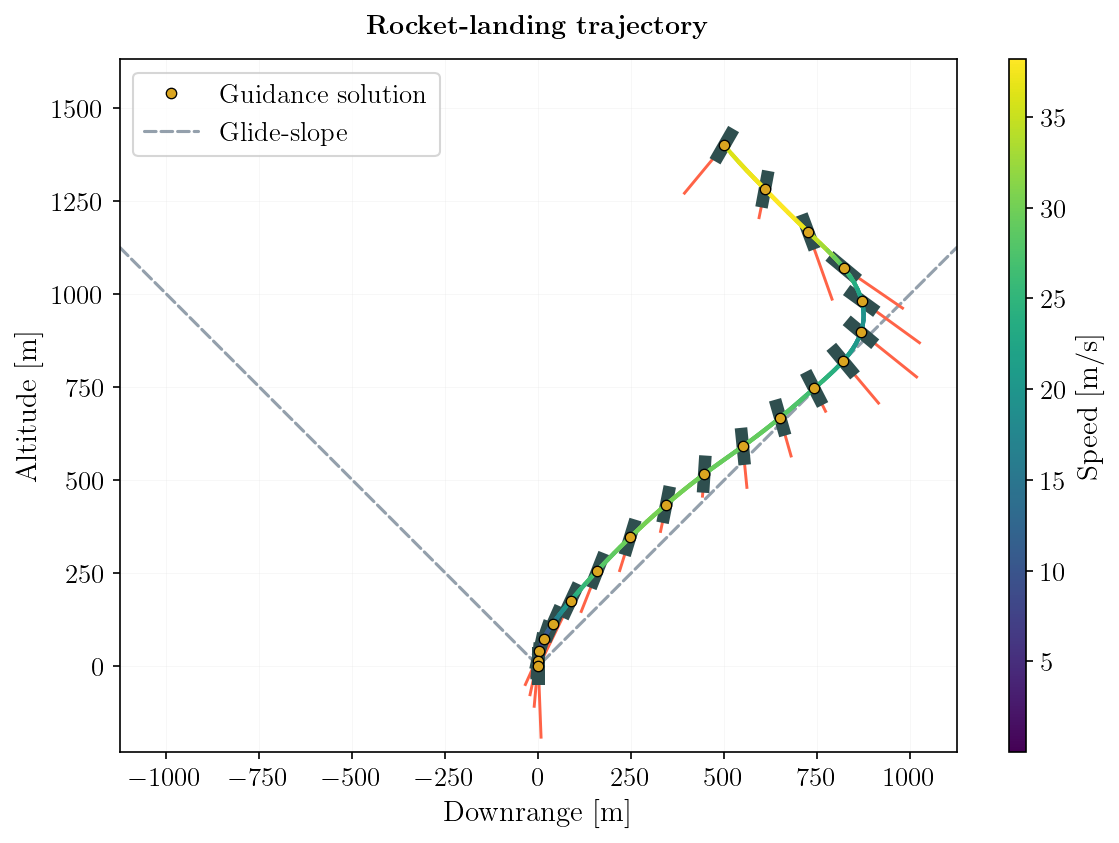

In [36]:
plot_trajectory();

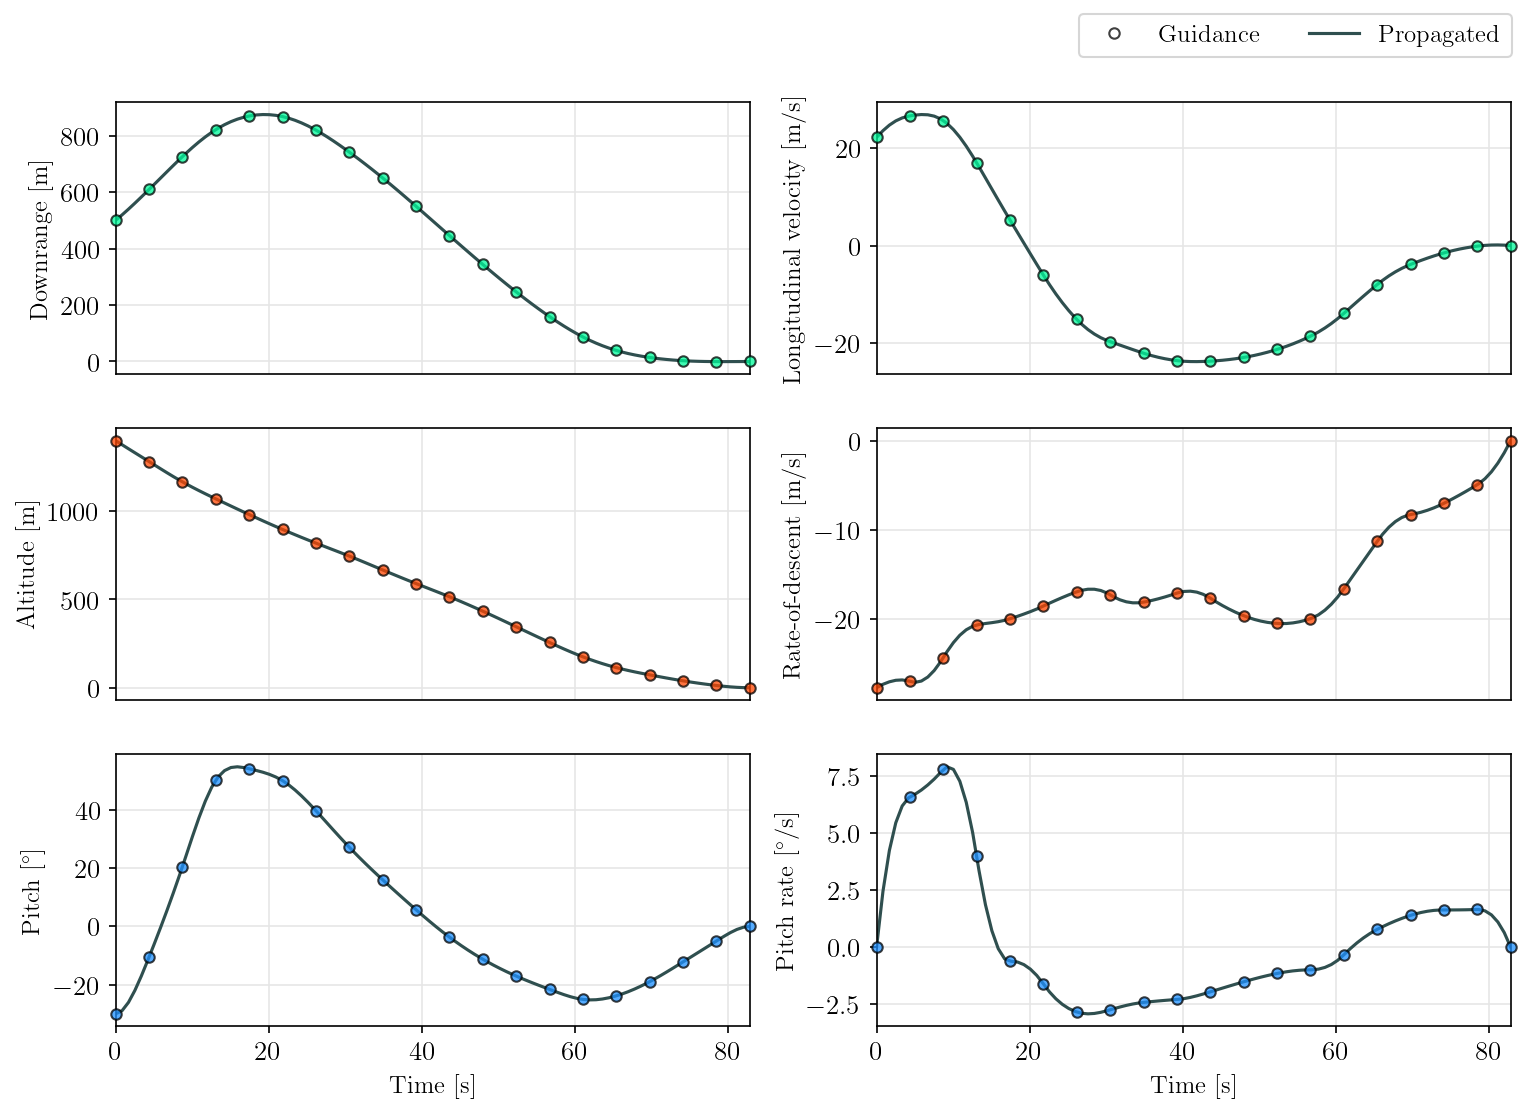

In [37]:
plot_states();

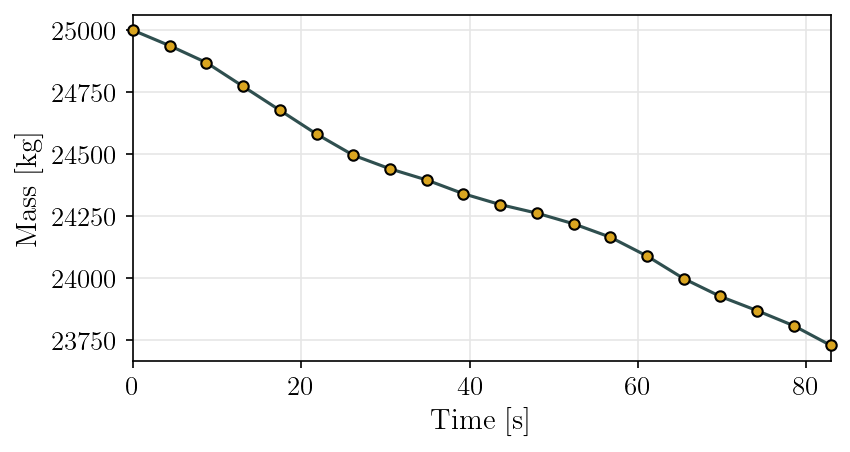

In [38]:
plot_mass();

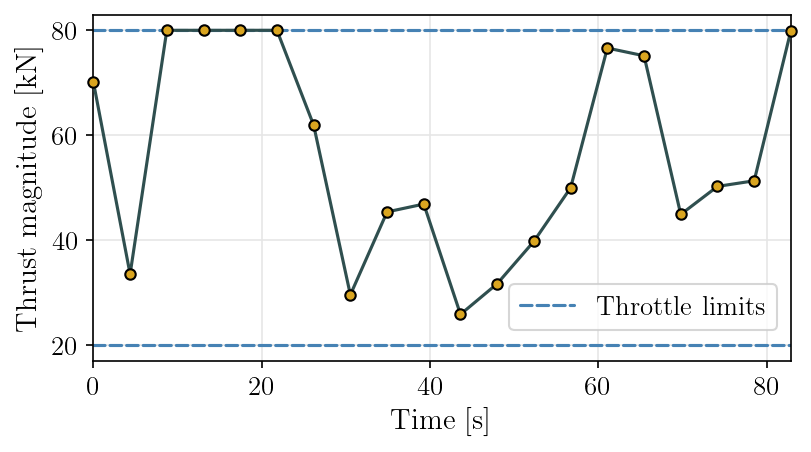

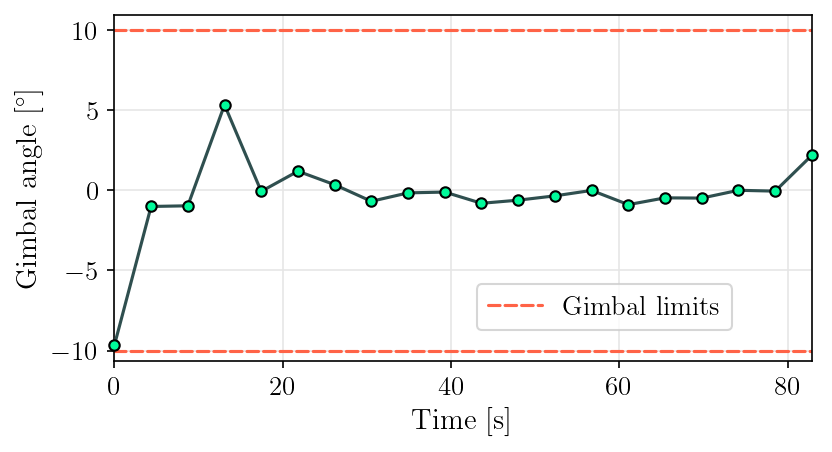

In [39]:
plot_controls();

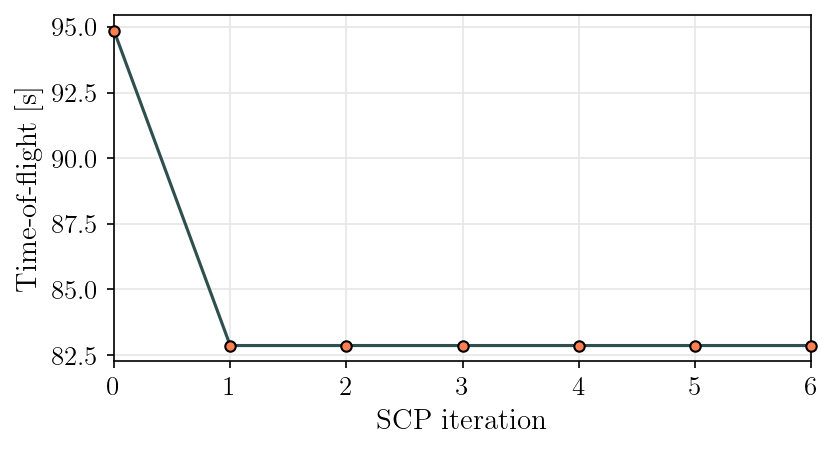

In [40]:
plot_ToF();